# PROJECT SECTIONS
- Dataset & Preprocessing
  - Fetching & Comparing Artist Genres w/ Spotify API
  - Moving/Dropping Columns
  - Scale Features
- Principle Component Analysis (PCA)
  - Apply on Features
  - Researching a More Optimal Feature Set
- Evalution Metrics
  - Elbow-Method (Experimenting w/ k value)
  - Silhouette Score ...
- KMeans
  - Fitting the Model
  - Light Feature Engineering (Cluster #, Dist to Centroid)
  - Cluster Subset & Filtering Output

In [54]:
# importing dependencies
from datasets import load_dataset
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import requests

## Dataset & Preprocessing

In [55]:
# loading from huggingface
# dataset_hf = load_dataset("maharshipandya/spotify-tracks-dataset")
# dataset = pd.DataFrame(dataset_hf['train'])   #convert dataset to pandas dataframe

#loading from local csv
dataset = pd.read_csv('spotify-tracks-dataset.csv')

# copy the dataset (for reference of original attributes)
data = dataset.copy()

# get genres from the dataset
genres = data['track_genre'].unique()
genres

# format genres to be searchable by keywords
genres_searchable = []
for genre in genres:
    if '-' in genre:    # format hyphenated genres into lists of strings
        genres_searchable.append(genre.split('-'))
    else:
        genres_searchable.append([genre])
genres_searchable
        


[['acoustic'],
 ['afrobeat'],
 ['alt', 'rock'],
 ['alternative'],
 ['ambient'],
 ['anime'],
 ['black', 'metal'],
 ['bluegrass'],
 ['blues'],
 ['brazil'],
 ['breakbeat'],
 ['british'],
 ['cantopop'],
 ['chicago', 'house'],
 ['children'],
 ['chill'],
 ['classical'],
 ['club'],
 ['comedy'],
 ['country'],
 ['dance'],
 ['dancehall'],
 ['death', 'metal'],
 ['deep', 'house'],
 ['detroit', 'techno'],
 ['disco'],
 ['disney'],
 ['drum', 'and', 'bass'],
 ['dub'],
 ['dubstep'],
 ['edm'],
 ['electro'],
 ['electronic'],
 ['emo'],
 ['folk'],
 ['forro'],
 ['french'],
 ['funk'],
 ['garage'],
 ['german'],
 ['gospel'],
 ['goth'],
 ['grindcore'],
 ['groove'],
 ['grunge'],
 ['guitar'],
 ['happy'],
 ['hard', 'rock'],
 ['hardcore'],
 ['hardstyle'],
 ['heavy', 'metal'],
 ['hip', 'hop'],
 ['honky', 'tonk'],
 ['house'],
 ['idm'],
 ['indian'],
 ['indie', 'pop'],
 ['indie'],
 ['industrial'],
 ['iranian'],
 ['j', 'dance'],
 ['j', 'idol'],
 ['j', 'pop'],
 ['j', 'rock'],
 ['jazz'],
 ['k', 'pop'],
 ['kids'],
 ['latin

#### Authenticating to Spotify

In [56]:
from dotenv import load_dotenv
import os
import requests
import json

# Load environment variables
load_dotenv()
client_id = os.getenv('SPOTIFY_CLIENT_ID')
client_secret = os.getenv('SPOTIFY_CLIENT_SECRET')

if not client_id or not client_secret:
    raise ValueError("SPOTIFY_CLIENT_ID or SPOTIFY_CLIENT_SECRET not set in .env file")

# Request token from Spotify API
url = "https://accounts.spotify.com/api/token"
try:
    # Send POST request for token
    auth_response = requests.post(
        url,
        headers={"Content-Type": "application/x-www-form-urlencoded"},
        data={"grant_type": "client_credentials"},
        auth=(client_id, client_secret),
    )

    # Check if the response is successful
    if auth_response.status_code == 200:
        token_data = auth_response.json()
        
        # Save token to JSON file
        with open("token.json", "w") as file:
            json.dump(token_data, file)
        print("Token successfully fetched and saved.")
    else:
        print("Error fetching token:", auth_response.status_code, auth_response.text)
        exit()

except requests.exceptions.RequestException as e:
    print("Error during token request:", str(e))
    exit()

# Load token from JSON and validate
try:
    with open('token.json', 'r') as file:
        token_data = json.load(file)
        token = token_data.get('access_token')
        token_type = token_data.get('token_type')

        if not token or not token_type:
            raise ValueError("Access token or token type not found in the response")

        # Validation successful, do not print sensitive details
        print("Token loaded successfully and ready for use.")

except FileNotFoundError:
    print("Error: token.json file not found")
except ValueError as e:
    print("Error parsing token:", str(e))
except json.JSONDecodeError:
    print("Error decoding JSON file")



Token successfully fetched and saved.
Token loaded successfully and ready for use.


#### Define Track/Song (via API)

In [57]:
# test track audio features
track_id = '3SktMqZmo3M9zbB7oKMIF7'
aud_features_url = "https://api.spotify.com/v1/audio-features/"

aud_features_json = requests.get(aud_features_url + track_id, headers={'Authorization': f'{token_type} {token}'}).json()

In [58]:
# test get track
track_url = "https://api.spotify.com/v1/tracks/"

# get track json data
track_json = requests.get(track_url + track_id, headers={'Authorization': f'{token_type} {token}'}).json()

# extract track artists and name
track_artists_list = [artist['name'] for artist in track_json['artists']]
track_artists_str = ', '.join(track_artists_list)
track_name = track_json['name']
artist_id = track_json['artists'][0]['id']
track_name, track_artists_str

('Gravity', 'John Mayer')

#### Fetch Track Artist's Genres

In [59]:
# TODO: See if genres_searchable is preventing matches 
# TODO: Ensure multi-artist tracks include all genres

artist_url = "https://api.spotify.com/v1/artists/"

# get album json data
artist_json = requests.get(artist_url + artist_id, headers={'Authorization': f'{token_type} {token}'}).json()
artist_genres = artist_json['genres']

# separate words in artist genres
artist_genres_words = [genre.split() for genre in artist_genres]

# flatten list
artist_genres_words = list(set([word for genre in artist_genres_words for word in genre]))
print(f"artist_genres_words: {artist_genres_words}") # TODO: fix

# print genres that are in the dataset
genre_response = 'GENRES IN DATASET & ASSOCIATED W/ TRACK ARTIST: '
for word in artist_genres_words:
    if word in genres:
        genre_response += '\n' + word
print(genre_response)

artist_genres_words: ['neo', 'singer-songwriter', 'mellow']
GENRES IN DATASET & ASSOCIATED W/ TRACK ARTIST: 
singer-songwriter


#### Drop & Move Columns

In [60]:
# unnecessary columns TODO: Check Train Dataset for Columns or Features
# Filter only columns that exist in the DataFrame
cols_to_drop = ['Unnamed: 0', 'album_name', 'loudness', 'explicit', 
                'time_signature', 'instrumentalness', 'duration_ms', 
                'mode', 'valence']

dataset.drop(cols_to_drop, axis=1, inplace=True)

# Drop duplicates (tracks with the same track_id)
dataset.drop_duplicates(subset='track_id', keep='first', inplace=True)

# Reorder columns based on position_map
position_map = {
    "track_name": 0,
    "artists": 1,
    "track_genre": 2,
    "track_id": 3
}

for attribute, position in position_map.items():
    if attribute in dataset.columns:  # Ensure column exists before reordering
        col_data = dataset.pop(attribute)
        dataset.insert(position, attribute, col_data)

# Print first 5 rows
dataset.head()

,track_name,artists,track_genre,track_id,popularity,danceability,energy,key,speechiness,acousticness,liveness,tempo
0,Comedy,Gen Hoshino,acoustic,5SuOikwiRyPMVoIQDJUgSV,73,0.676,0.4610,1,0.1430,0.0322,0.3580,87.917
1,Ghost - Acoustic,Ben Woodward,acoustic,4qPNDBW1i3p13qLCt0Ki3A,55,0.420,0.1660,1,0.0763,0.9240,0.1010,77.489
2,To Begin Again,Ingrid Michaelson;ZAYN,acoustic,1iJBSr7s7jYXzM8EGcbK5b,57,0.438,0.3590,0,0.0557,0.2100,0.1170,76.332
3,Can't Help Falling In Love,Kina Grannis,acoustic,6lfxq3CG4xtTiEg7opyCyx,71,0.266,0.0596,0,0.0363,0.9050,0.1320,181.740
4,Hold On,Chord Overstreet,acoustic,5vjLSffimiIP26QG5WcN2K,82,0.618,0.4430,2,0.0526,0.4690,0.0829,119.949


## Principle Component Analysis (PCA)

#### Feature Scaling

In [61]:
# feature scale the data (except first column)
scaler = StandardScaler()

# turn data into float type
dataset.iloc[:, 4:] = dataset.iloc[:, 4:].values.astype(float)

# feature scale the data (except label-encoded data)
dataset.iloc[:, 4:] = scaler.fit_transform(dataset.iloc[:, 4:])


/var/folders/b6/6366288j429498w43rvsw48w0000gn/T/ipykernel_85028/448834751.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.93392568  1.05932026  1.15649864 ... -0.54412302  0.37907159
 -0.54412302]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.iloc[:, 4:] = scaler.fit_transform(dataset.iloc[:, 4:])
/var/folders/b6/6366288j429498w43rvsw48w0000gn/T/ipykernel_85028/448834751.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.20328584 -1.20328584 -1.48419444 ... -1.48419444  0.48216576
 -1.20328584]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.iloc[:, 4:] = scaler.fit_transform(dataset.iloc[:, 4:])


#### Applying PCA

In [62]:
# run pca to reduce the number of features to 2
pca = PCA(n_components=2)
data_pca = pca.fit_transform(dataset.iloc[:, 4:])

# print columns in PCA
feature_names = dataset.columns[4:]
print('Features to include in PCA:\n', feature_names)

Features to include in PCA:
 Index(['popularity', 'danceability', 'energy', 'key', 'speechiness',
       'acousticness', 'liveness', 'tempo'],
      dtype='object')


## Evalution Metrics

#### Elbow Method

In [63]:
X_pca = data_pca

# Perform clustering for a range of cluster numbers
inertia = []  # To store the sum of squared distances (inertia)
K = range(1, 11)  # Number of clusters to try

for k in K:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(X_pca)
    inertia.append(kmeans_test.inertia_)

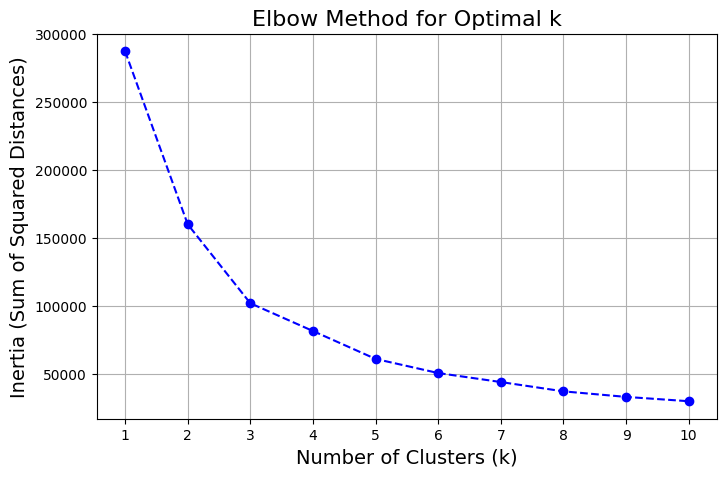

In [64]:
# Plotting Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=14)
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xticks(K)
plt.grid(True)
plt.show()

##### Elbow at 3 clusters I think?

#### Silhouette Score

In [65]:
from sklearn.utils import resample

# Reduce the size of the dataset for silhouette computation
sampled_X_pca = resample(X_pca, n_samples=5000, random_state=42)  # Adjust n_samples as needed

# Recalculate silhouette scores with sampled data
silhouette_scores = []
for k in range(2, 11):
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    labels = kmeans_test.fit_predict(sampled_X_pca)
    score = silhouette_score(sampled_X_pca, labels)
    silhouette_scores.append(score)


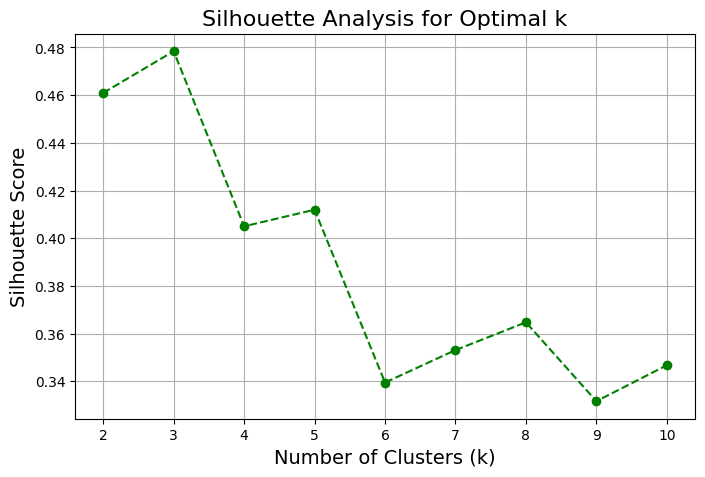

In [66]:
# Step 3: Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--', color='g')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Analysis for Optimal k', fontsize=16)
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()


#### TODO (Optional): Davies Bouldin Index

## KMeans

#### Fit K-Means to Data

In [67]:
# create kmeans++ model
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init='auto', random_state=0)
pred_y = kmeans.fit_predict(data_pca)

## Sort Dataset by Cluster & Distance-to-Cluster


In [68]:
# add a column to the dataset for the cluster number and distance from the centroid
dataset['cluster'] = pred_y
dataset['distance'] = kmeans.fit_transform(data_pca).min(axis=1)

# sort the dataset by cluster and distance
dataset = dataset.sort_values(by=['cluster', 'distance'])

# print the first 10 rows
dataset.head(10)


,track_name,artists,track_genre,track_id,popularity,danceability,energy,key,speechiness,acousticness,liveness,tempo,cluster,distance
11053,Kiss from a Rose,Seal,british,3YKptz29AsOlm7WAVnztBh,1.982515,0.123574,-0.395388,1.324892,-0.502682,1.051407,0.456840,0.321631,0,0.001717
54154,isle of the blest,tstewart;Machinedrum,idm,3jW0pK6SS8vH2wKLjlBLBm,0.233304,-0.866860,-0.056343,1.605800,-0.477964,0.906574,-0.492446,0.596024,0,0.009649
56650,Hrs & Hrs,Muni Long,indie-pop,3M5azWqeZbfoVkGXygatlb,2.128282,-0.221663,-0.442152,0.201257,0.631711,0.823811,-0.564284,0.394944,0,0.011405
84801,An American Prayer,Jim Morrison;The Doors,psych-rock,2VDkE9sdVpQAgEqH5fvTMV,0.573428,0.802729,-0.808476,0.482166,-0.236960,0.244476,0.082257,-0.387461,0,0.012702
97597,Um Degrau Na Escada,Chico Rey & Paraná,sertanejo,5Pn6spaFtc1kEk2HI86SaW,0.573428,-0.012257,-0.130387,-0.360560,-0.543291,0.906574,-0.107600,0.404142,0,0.016436
94794,Walking Through The Rain,SadBoyProlific;Iriasona,sad,03Nx63Qf5HnqGF3KkGIJ6l,0.913553,0.282044,-1.050094,0.482166,0.684679,1.054363,-0.595072,1.795797,0,0.018445
8735,Casa Con Diez Pinos,Manal,blues,2Ras7UcXvzenVmkyVMibdh,0.087536,-0.193365,-0.278476,-0.922377,-0.409988,1.116435,-0.348770,1.538803,0,0.018461
40466,Tu És Meu Socorro,Marcos Freire,gospel,7ehQuGJjYtcJ03dlA8uK3B,0.379072,-0.295238,-0.321344,-0.922377,-0.507979,-0.287566,-0.297458,-1.069194,0,0.018643
20127,Love Me More,Sam Smith,dance,4gVEvqKXRFe2WarhQxMzjP,-1.467318,1.295116,-0.761712,1.324892,-0.202531,-0.077705,-0.466790,-1.230331,0,0.018941
41286,Just Plain Bad,Angry Johnny and the Killbillies,goth,3TUIbBibx1RMF67PdrN2Bm,-0.301177,-0.855541,-0.851344,1.043983,-0.381739,-0.835570,-0.548890,-0.952517,0,0.019270


# Song Recommendations

In [69]:
# search for song's full data using the track_id
song_matches = dataset[dataset['track_id'] == track_id]

# get the first occurrence
full_given_song = song_matches.loc[song_matches.first_valid_index()]

# save the numerical data in a separate variable
given_song = full_given_song[4:].astype(float)

# print the full given song data
print(f"DATA FROM: {track_name} by {track_artists_str}")
given_song

DATA FROM: Gravity by John Mayer


popularity      1.885336
danceability    1.080051
energy         -1.202079
key             0.482166
speechiness    -0.470019
acousticness    1.190329
liveness        0.118176
tempo           0.057797
cluster         0.000000
distance        0.730713
Name: 99261, dtype: float64

## Initial Cluster Points & Filtering

In [70]:
# find the closest centroid

# get the index of the closest centroid
closest_centroid_idx = int(given_song['cluster'])

# get the coordinates of the closest centroid
closest_centroid = kmeans.cluster_centers_[closest_centroid_idx]

# Find data points belonging to the closest cluster
cluster_points = dataset.iloc[:, :][kmeans.labels_ == closest_centroid_idx]

# Remove the given song from the closest cluster if it exists
cluster_points = cluster_points[cluster_points['track_name'] != full_given_song['track_name']]

# Only consider songs of the same genre
# TODO: create clusters of genres that are similar and only from the that cluster
cluster_points = cluster_points[cluster_points['track_genre'] == full_given_song['track_genre']]

# print the amount of songs filtered
print(cluster_points.shape)

cluster_points.head(10)

(130, 14)


,track_name,artists,track_genre,track_id,popularity,danceability,energy,key,speechiness,acousticness,liveness,tempo,cluster,distance
99364,Someone New,Hozier,singer-songwriter,22sS7JkzeVeq4vOPCB6Fbj,1.642391,0.174511,-0.372005,0.482166,-0.463839,0.232653,0.354214,-0.998703,0,0.056481
99913,Tui Ki Kore Dili,Anupam Roy,singer-songwriter,3tCexBo7fH5BspYwQ0mr1g,-0.009642,1.130987,-0.481123,1.324892,-0.500916,0.608039,0.077126,-0.204643,0,0.146212
99958,Lamhe Zaroori,Neyhal,singer-songwriter,6hkLuLZ3x5hb5Vr3mbScZF,-0.155409,0.429194,0.091745,1.324892,-0.526517,0.729226,-0.554021,-0.731084,0,0.200474
99572,Angel Of Small Death & The Codeine Scene,Hozier,singer-songwriter,1SCXzqKZdif5b33POmzwI4,1.399445,-1.047968,0.013804,-0.360560,-0.290811,-0.340770,-0.497577,-0.976656,0,0.238150
99747,Jag har väntat på ett regn,Lars Winnerbäck,singer-songwriter,1iIk4Q10fffmVs3WPvDfxU,-1.613085,-0.521623,-0.527888,-1.203286,-0.447949,-0.606791,-0.554021,-0.519578,0,0.286832
99668,KEEP IT TO YOURSELF,Clinton Kane,singer-songwriter,6UcfBPUiBB7ZeQQkwZ8OF5,1.350855,-0.391452,-0.107005,-1.484194,-0.294342,0.912485,-0.640740,0.337170,0,0.320994
99961,Jaago Uma,Anupam Roy;Rupankar Bagchi,singer-songwriter,6HoxQTzbgOilzBMZEYqGw4,-0.009642,-1.630909,-0.114799,-0.922377,-0.424996,1.134169,-0.718222,1.501383,0,0.333970
99604,Woh Purana Pyar,Suzonn,singer-songwriter,7977HqRRgSuVc9hzJFJvmE,0.087536,-0.397111,-0.711050,-0.079651,-0.524752,0.197184,-0.482184,-0.398419,0,0.348639
99179,Fingers Crossed,Lauren Spencer Smith,singer-songwriter,3yMC1KsTwh0ceXdIe4QQAQ,2.322639,-0.012257,-0.629211,-0.079651,-0.301405,0.856325,0.477365,-0.419835,0,0.390827
99018,Numb Little Bug,Em Beihold,singer-songwriter,3o9kpgkIcffx0iSwxhuNI2,2.176872,1.017795,-0.418770,0.763074,-0.093065,-0.003810,0.169489,-1.231327,0,0.415222


## Song Recommendation

In [71]:
from sklearn.metrics.pairwise import euclidean_distances

# get all distances of data points in the cluster from the given song
distances = euclidean_distances([given_song.iloc[:8]], cluster_points.iloc[:, 4:12]) # 4:12 are the numerical features

# get the indices of the 10 closest songs
closest_songs_indices = distances.argsort()[0][:10]

# get the 10 closest songs
closest_songs = cluster_points.iloc[closest_songs_indices]

# print the 10 closest songs
closest_songs

,track_name,artists,track_genre,track_id,popularity,danceability,energy,key,speechiness,acousticness,liveness,tempo,cluster,distance
99186,Unloving You,Anson Seabra,singer-songwriter,2w9nvs1ByWUGkED4M0ug34,1.690980,1.147966,-0.940976,0.201257,-0.497385,0.900662,-0.384689,-0.004958,0,0.853421
99511,It's You,Sezairi,singer-songwriter,7rdnB5DAyPbaj51TCQRcqW,1.933926,0.383917,-0.695461,0.763074,-0.492088,0.640552,-0.528365,0.526496,0,0.827391
99962,Love on the Weekend,John Mayer,singer-songwriter,0j2WBxWZnWti5TpSxjJvPb,1.350855,0.944220,-0.344726,0.482166,-0.520338,0.646464,-0.779284,-0.070302,0,0.943345
99619,Superhero,Hayd,singer-songwriter,4NXROG27qc3PGsf6IK5MOD,1.253677,0.361278,-1.985389,1.043983,-0.315529,1.621875,0.692879,-0.071431,4,0.415895
99027,Head In The Clouds,Hayd,singer-songwriter,3CeKc83EsgRPItgvlDHo5B,1.836747,1.221541,-1.950315,-0.360560,-0.325240,1.887896,-0.633043,-0.198567,4,1.374931
99179,Fingers Crossed,Lauren Spencer Smith,singer-songwriter,3yMC1KsTwh0ceXdIe4QQAQ,2.322639,-0.012257,-0.629211,-0.079651,-0.301405,0.856325,0.477365,-0.419835,0,0.390827
99708,Suffocate,Hayd,singer-songwriter,1ydKLmtx7LYnDe1udTu96w,1.205088,0.514088,-2.244933,-0.360560,-0.381739,1.533201,-0.215357,-0.000044,4,0.857505
99577,Some Days,Brent Morgan,singer-songwriter,6vfZSkjmzjo6q5BhkWSRxY,1.205088,0.038680,-1.537227,0.201257,-0.514158,1.636654,-0.700263,0.595759,4,1.278222
99460,the same,mehro,singer-songwriter,03OjIsSVv8mwp58p3iK87o,1.448034,0.117914,-0.508402,-0.079651,-0.514158,1.571626,-0.584809,0.729967,0,0.744518
99353,Mayonaka No Door / Stay With Me,Chris Andrian Yang,singer-songwriter,6EgwlXnFrfkFqOKqY3dqki,1.205088,1.080051,-2.148286,1.043983,-0.370263,1.459306,-0.697184,-0.735533,4,1.328646
